ToggleButtons(description='Mode:', options=(('Foreground', 'foreground'), ('Background', 'background')), value…

Button(description='Run Graph-Cut', style=ButtonStyle())

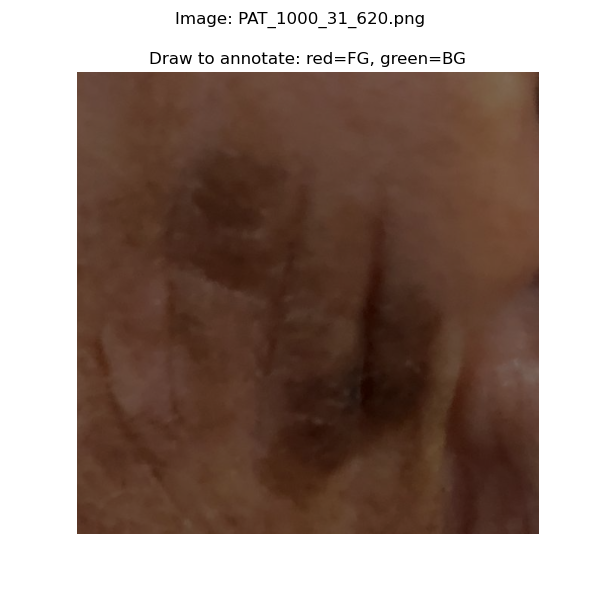

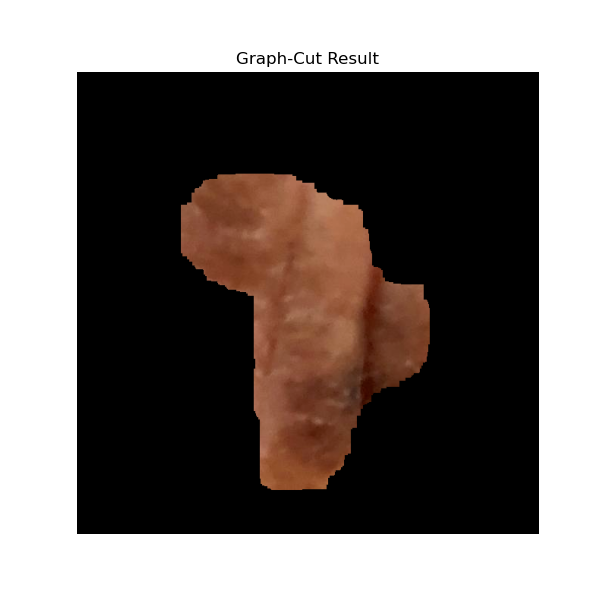

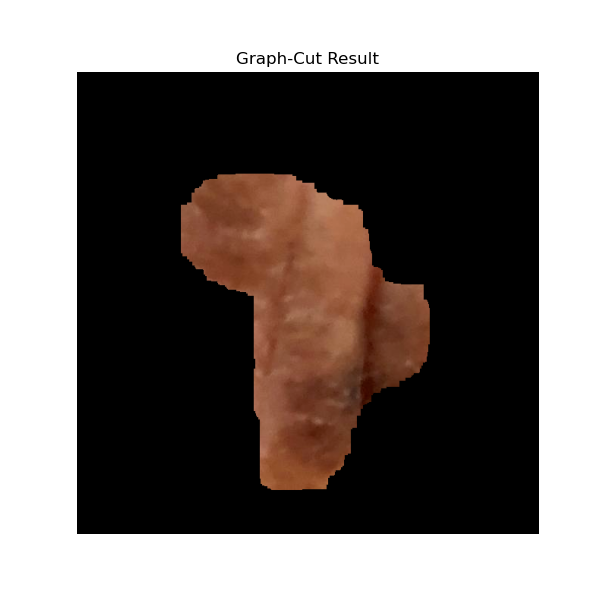

In [3]:
%matplotlib widget

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib.patches import Circle
import maxflow

# ------------------- Load image -------------------
base_path = os.getcwd()
images_path = os.path.abspath(os.path.join(base_path, "..", "data", "skin_images"))
image_files = [f for f in os.listdir(images_path) if f.lower().endswith('.png')]
if not image_files:
    raise ValueError("No PNG images found in skin_images folder.")

image_path = os.path.join(images_path, image_files[0])
image_bgr = cv2.imread(image_path)
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# --------------------------------------------------

# ------------------- Initialize variables -------------------
scribble_mask = np.zeros(image.shape[:2], dtype=np.uint8)
overlay_data = np.zeros_like(image, dtype=np.uint8)
brush_radius = 15
current_mode = 'foreground'
mask_value = 1
dragging = False
# ------------------------------------------------------------

def draw_xy(x, y, color):
    global overlay_data, scribble_mask
    cv2.circle(scribble_mask, (x, y), brush_radius, mask_value, -1)
    cv2.circle(overlay_data, (x, y), brush_radius, color, -1)
    overlay_img.set_data(overlay_data)
    fig.canvas.draw_idle()

def on_press(event):
    global dragging
    if event.inaxes != ax:
        return
    dragging = True
    draw_xy(int(event.xdata), int(event.ydata),
            (255, 0, 0) if current_mode == 'foreground' else (0, 255, 0))

def on_motion(event):
    if not dragging or event.inaxes != ax:
        return
    draw_xy(int(event.xdata), int(event.ydata),
            (255, 0, 0) if current_mode == 'foreground' else (0, 255, 0))

def on_release(event):
    global dragging
    dragging = False

def on_mode_change(change):
    global current_mode, mask_value
    current_mode = change['new']
    mask_value = 1 if current_mode == 'foreground' else 2

# ------------------- Graph-cut core -------------------
def run_graph_cut(img, scribbles, lambda_val=50, sigma=10):
    H, W = img.shape[:2]
    img = img.astype(np.float64)

    fg_pixels = img[scribbles == 1]
    bg_pixels = img[scribbles == 2]

    fg_mean = np.mean(fg_pixels, axis=0) if np.any(fg_pixels) else np.zeros(3)
    bg_mean = np.mean(bg_pixels, axis=0) if np.any(bg_pixels) else np.zeros(3)

    data_cost_fg = np.sum((img - fg_mean) ** 2, axis=2)
    data_cost_bg = np.sum((img - bg_mean) ** 2, axis=2)

    data_cost_fg /= np.max(data_cost_fg) + 1e-8
    data_cost_bg /= np.max(data_cost_bg) + 1e-8

    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes((H, W))

    source_cap = data_cost_fg.copy()
    sink_cap = data_cost_bg.copy()

    source_cap[scribbles == 1] = 1e10  # hard-assign FG
    sink_cap[scribbles == 2] = 1e10    # hard-assign BG

    g.add_grid_tedges(nodeids, source_cap, sink_cap)

    for i in range(H):
        for j in range(W - 1):
            diff = img[i, j] - img[i, j + 1]
            weight = lambda_val * np.exp(-np.sum(diff**2) / (2 * sigma**2))
            g.add_edge(nodeids[i, j], nodeids[i, j + 1], weight, weight)

    for i in range(H - 1):
        for j in range(W):
            diff = img[i, j] - img[i + 1, j]
            weight = lambda_val * np.exp(-np.sum(diff**2) / (2 * sigma**2))
            g.add_edge(nodeids[i, j], nodeids[i + 1, j], weight, weight)

    g.maxflow()
    seg_mask = np.zeros((H, W), dtype=bool)
    for i in range(H):
        for j in range(W):
            seg_mask[i, j] = g.get_segment(nodeids[i, j]) == 0
    return seg_mask
# ----------------------------------------------------

# ------------------- Button event -------------------
def on_segment_clicked(b):
    print("Running Graph-Cut...")
    result = run_graph_cut(image, scribble_mask)
    result_img = np.zeros_like(image)
    result_img[result] = image[result]

    fig2, ax2 = plt.subplots(figsize=(6, 6))
    ax2.imshow(result_img)
    ax2.set_title("Graph-Cut Result")
    ax2.axis('off')
    plt.show()
# ----------------------------------------------------

# ------------------- UI setup -------------------
fig, ax = plt.subplots(figsize=(6, 6), num=image_files[0])
fig.suptitle(f"Image: {image_files[0]}", fontsize=12)
ax.imshow(image)
overlay_img = ax.imshow(overlay_data, alpha=0.5)
ax.set_title("Draw to annotate: red=FG, green=BG")
ax.axis('off')

fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('motion_notify_event', on_motion)
fig.canvas.mpl_connect('button_release_event', on_release)

mode_selector = widgets.ToggleButtons(
    options=[('Foreground', 'foreground'), ('Background', 'background')],
    description='Mode:',
)
mode_selector.observe(on_mode_change, names='value')
display(mode_selector)

segment_button = widgets.Button(description="Run Graph-Cut")
segment_button.on_click(on_segment_clicked)
display(segment_button)

on_mode_change({'new': 'foreground'})  # set default mode
plt.show()
# -----------------------------------------------------
